In [6]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [7]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [8]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/groot/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/groot/Projects/neuroaging/figures/fig2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [9]:
metric = "adc"
distribution_metric = "qfmean"
data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)

data["age_squared"] = data["age_at_scan"] ** 2
data["sex"] = data["sex"].map({"M": 0, "F": 1})

/tmp/ipykernel_231985/2902801396.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [10]:
metric_col = "volume" if metric == "gm_vol" else distribution_metric

In [11]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [12]:
def assign_weights_by_population(
    data: pd.DataFrame,
    population_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    range_start: str = "range_start",
    range_end: str = "range_end",
    total: str = "total",
) -> np.ndarray:
    """
    Post-stratification weights so the age distribution of *data*
    matches an external reference.

    - Accepts integer or float ages.
    - Handles boundary ages (include_lowest=True).
    - Leaves bins with zero sample untouched (weight=0 → later dropped).
    - Returns weights whose mean == 1 across *non-zero* weights.
    """

    # 1. Make sure population bins are well-formed
    pop = (
        population_df[[range_start, range_end, total]]
        .sort_values(range_start)
        .reset_index(drop=True)
    )
    if (pop[range_end] <= pop[range_start]).any():
        raise ValueError("Each range_end must exceed range_start.")
    if (pop[range_start].iloc[1:].values < pop[range_end].iloc[:-1].values).any():
        raise ValueError("Age bins overlap or are not strictly increasing.")

    # 2. Bin edges for pd.cut  →  [..., last_end]  (right-inclusive)
    bin_edges = pop[range_start].tolist() + [pop[range_end].iloc[-1]]

    # Population proportions (works for % or counts)
    pop_prop = pop[total] / pop[total].sum()

    # 3. Assign each participant to a bin
    sample_bins = pd.cut(
        data[age_col],
        bins=bin_edges,
        right=True,            # include right edge
        include_lowest=True,   # include first left edge
        labels=pop.index,      # integer labels 0..n-1
    )

    # 4. Sample distribution
    sample_counts = sample_bins.value_counts(sort=False)
    sample_prop = sample_counts / sample_counts.sum()

    # 5. Weight lookup  (population / sample)  — careful with zeros
    weight_lookup = pop_prop / sample_prop.replace(0, np.nan)

    # 6. Map to rows; bins with zero sample → NaN weight → drop later
    w = sample_bins.map(weight_lookup).to_numpy()

    # Assign *zero* weight (instead of 1) to rows that were NaN
    w = np.where(np.isnan(w), 0.0, w)

    # 7. Rescale so mean(weight > 0) == 1
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    return w


In [13]:
import numpy as np
import pandas as pd

# ─────────────────────────────────────────────────────────────────────────────
def compute_poststrat_weights(
    sample_df: pd.DataFrame,
    pop_df: pd.DataFrame,
    *,
    age_col: str = "age_at_scan",
    start_col: str = "range_start",
    end_col: str = "range_end",
    pop_total_col: str = "total",
    cap: float | None = None,
    return_bin_table: bool = False,
):
    """
    Post-stratification weights so that the age distribution of *sample_df*
    matches an external population distribution supplied in *pop_df*.

    Parameters
    ----------
    sample_df : DataFrame with an ``age_col`` column (years; int or float).
    pop_df    : DataFrame with columns
                    [start_col, end_col, pop_total_col].
                * Values in ``pop_total_col`` can be counts **or** percentages
                  (they are internally re-scaled to proportions).
                * The row order doesn’t matter; they will be sorted.
    cap       : Optional float.  If provided, weights are truncated at  
                ``cap × mean(weight)`` and then re-scaled so mean(weight)=1.
    return_bin_table : If True, also return a DataFrame summarising
                       n_sample, n_pop, and weight_factor for every bin.

    Returns
    -------
    weights   : 1-D numpy array aligned with ``sample_df.index``.
    bin_table : (optional) tidy per-bin summary (see above).
    """

    # 1 ── tidy & validate the population table --------------------------------
    pop = (
        pop_df[[start_col, end_col, pop_total_col]]
        .dropna()
        .astype({start_col: int, end_col: int, pop_total_col: float})
        .sort_values(start_col)         # your CSV is descending; fix that
        .reset_index(drop=True)
    )

    if (pop[end_col] <= pop[start_col]).any():
        raise ValueError("Each range_end must exceed range_start.")

    if (pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values).any():
        overlap = pop.iloc[
            np.where(
                pop[start_col].iloc[1:].values < pop[end_col].iloc[:-1].values
            )[0] + 1
        ][[start_col, end_col]]
        raise ValueError(
            "Age bins overlap (rows shown below) — "
            "merge / correct them before weighting:\n"
            f"{overlap}"
        )

    # 2 ── build right-inclusive bin edges  (···| s_i  …  e_i | s_{i+1} …) ----
    edges = pop[start_col].tolist() + [pop[end_col].iloc[-1]]

    # 3 ── assign every participant to a bin -----------------------------------
    s_bins = pd.cut(
        sample_df[age_col],
        bins=edges,
        right=True,
        include_lowest=True,
        labels=pop.index,       # categorical labels 0,1,…
    )

    # 4 ── compute *sample* and *population* proportions per bin --------------
    n_sample = s_bins.value_counts(sort=False).sort_index()
    prop_sample = n_sample / n_sample.sum()

    prop_pop = pop[pop_total_col] / pop[pop_total_col].sum()

    # 5 ── weight factor = pop_prop / sample_prop ------------------------------
    weight_factor = prop_pop / prop_sample.replace(0, np.nan)   # avoid /0 → NaN

    # 6 ── map factor back to each row ----------------------------------------
    w = s_bins.map(weight_factor).astype(float).to_numpy()
    w = np.where(np.isnan(w), 0.0, w)      # rows that fell outside bins → 0

    # 7 ── optional weight truncation (winsorisation) --------------------------
    if cap is not None and cap > 0:
        mean_pos = w[w > 0].mean()
        w = np.clip(w, 0, cap * mean_pos)

    # 8 ── re-scale so mean(weight > 0) == 1 -----------------------------------
    positive = w > 0
    w[positive] = w[positive] / w[positive].mean()

    # 9 ── return --------------------------------------------------------------
    if return_bin_table:
        bin_tbl = pd.DataFrame(
            {
                "n_sample": n_sample,
                "n_pop": prop_pop * n_sample.sum(),   # rescaled to sample size
                "prop_sample": prop_sample,
                "prop_pop": prop_pop,
                "weight_factor": weight_factor,
            }
        )
        return w, bin_tbl

    return w


In [14]:
# assign weights
data["weight"],_ = compute_poststrat_weights(
    data,
    israel_population,
    age_col="age_at_scan",
    cap=None,  # try None first; if still spiky, use 4 or 5
    return_bin_table=True,
)

In [15]:
from statsmodels.formula.api import ols, wls

def regional_models(region_data:pd.DataFrame, metric_col:str, model:str, covariates:list):
    """
    Fit a linear model to the data for each region.
    """
    # Fit the model
    if model == "ols":
        model = ols(f"{metric_col} ~ {' + '.join(covariates)}", data=region_data)
    elif model == "wls":
        model = wls(f"{metric_col} ~ {' + '.join(covariates)}", data=region_data, weights=region_data["weight"])
    else:
        raise ValueError("Model must be either 'ols' or 'wls'.")

    # Fit the model
    results = model.fit()

    # Return the results
    return results

In [16]:
from tqdm import tqdm
# Set up dataframes to store results
lin_unw, lin_w, quad_unw, quad_w = parcels.copy(), parcels.copy(), parcels.copy(), parcels.copy()

covariates = ["age_at_scan", "sex"]
if metric == "gm_vol":
    covariates += ["tiv"]

for i, row in tqdm(parcels.iterrows(), total=parcels.shape[0], desc="Fitting models"):
    region_data = data[data[region_col] == row[region_col]].copy()
    region_data.rename(columns={metric_col: "value"}, inplace=True)
    for results_df, model, is_quadratic in zip(
        [lin_unw, lin_w, quad_unw, quad_w],
        ["ols", "wls", "ols", "wls"],
        [False, False, True, True],
    ):
        # Fit the model
        if is_quadratic:
            region_data["age_squared"] = region_data["age_at_scan"] ** 2
            results = regional_models(region_data, "value", model, covariates + ["age_squared"])
        else:
            results = regional_models(region_data, "value", model, covariates)

        # Store the results
        results_df.loc[i, "model"] = results
        results_df.loc[i, "pvalue"] = results.f_pvalue
        results_df.loc[i, "r2"] = results.rsquared
        results_df.loc[i, "r2_adj"] = results.rsquared_adj
        results_df.loc[i, "n"] = len(region_data)
        # if i == 405 and model == "wls" and is_quadratic:
        #     a = results


Fitting models: 100%|██████████| 454/454 [00:09<00:00, 49.32it/s]


In [17]:
from statsmodels.stats.anova import anova_lm

unw_compare = parcels.copy()
w_compare = parcels.copy()

# do f test to compare between quadratic and linear models
for i, row in tqdm(parcels.iterrows(), total=parcels.shape[0], desc="Fitting models"):
    for results_lin, results_quad, results_df in zip(
        [lin_unw, lin_w],
        [quad_unw, quad_w],
        [unw_compare, w_compare],
    ):
        # collect models
        model1 = results_lin.loc[i, "model"]
        model2 = results_quad.loc[i, "model"]
        f, p, _ = model2.compare_f_test(model1)
        results_df.loc[i, "f"] = f
        results_df.loc[i, "pvalue"] = p
        results_df.loc[i, "n"] = model1.nobs
    results_df["log(f)"] = np.log(results_df["f"])
        # do f test to compare between quadratic and linear models
    # model1 = lin_unw.loc[i, "model"]
    # model2 = quad_unw.loc[i, "model"]
    # f, p, _ = model2.compare_f_test(model1)
    # unw_compare.loc[i, "f"] = f
    # unw_compare.loc[i, "pvalue"] = p
    # unw_compare.loc[i, "n"] = model1.nobs
    # weighted

Fitting models: 100%|██████████| 454/454 [00:00<00:00, 1176.67it/s]


In [18]:
# correct everything for multiple comparisons
from statsmodels.stats.multitest import multipletests

for results_df, save_name in zip([lin_unw, lin_w, quad_unw, quad_w, unw_compare, w_compare], ["lin_unw", "lin_w", "quad_unw", "quad_w", "unw_compare", "w_compare"]):
    results_df["p_corrected"] = multipletests(results_df["pvalue"], method="fdr_bh")[1]
    results_df.to_pickle(OUTPUT_DIR / f"{save_name}_{metric}.pkl")

In [19]:
# w_compare.sort_values("p_corrected").head(20)
(w_compare["p_corrected"] < 0.05).sum()

np.int64(414)

/tmp/ipykernel_231985/289078991.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


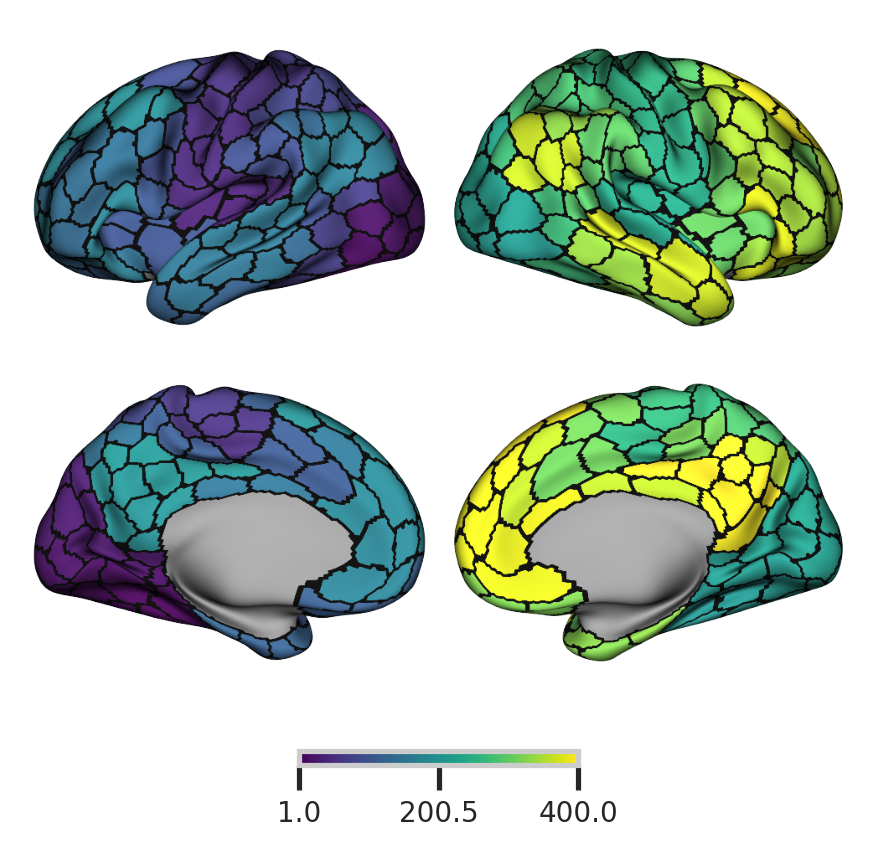

In [20]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation('schaefer')
p.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=True)

p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
            as_outline=True, cbar=False)
fig = p.build()
fig.show()

In [21]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [22]:
w_compare[w_compare["p_corrected"] < 0.05]

,index,name,base_name,Label Name,network,component,hemisphere,f,pvalue,n,log(f),p_corrected
0,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,450.566709,2.503311e-90,2000.0,6.110506,1.337063e-89
1,2,7Networks_LH_Vis_2,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,481.634319,8.272777e-96,2000.0,6.177185,5.365487e-95
2,3,7Networks_LH_Vis_3,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,451.202130,1.930688e-90,2000.0,6.111915,1.043491e-89
3,4,7Networks_LH_Vis_4,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,324.214352,2.760505e-67,2000.0,5.781405,9.215215e-67
4,5,7Networks_LH_Vis_5,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,531.015655,2.224548e-104,2000.0,6.274792,1.863469e-103
...,...,...,...,...,...,...,...,...,...,...,...,...
448,449,mAMY-lh,mAMY,"Amygdala, medial nucleus",subcortex,Amygdala,L,479.551101,1.918615e-95,2000.0,6.172850,1.193221e-94
449,450,THA-DP-lh,THA-DP,"Thalamus, dorso-posterior part",subcortex,Thalamus,L,223.294707,6.112522e-48,2000.0,5.408492,1.533196e-47
450,451,NAc-shell-lh,NAc-shell,"Nucleus Accumbens, shell",subcortex,Nucleus Accumbens,L,316.561044,7.541541e-66,2000.0,5.757516,2.481058e-65
451,452,NAc-core-lh,NAc-core,"Nucleus Accumbens, core",subcortex,Nucleus Accumbens,L,528.171403,6.859162e-104,2000.0,6.269421,5.369068e-103


In [30]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region":[],"value":[],"Hemisphere":[]}

# vis_df = w_compare
# value_column = "log(f)"
vis_df = quad_w
value_column = "r2_adj"
p_column = "p_corrected"

value_map_lh = {}  # New: separate map for left hemisphere
value_map_rh = {}  # New: separate map for right hemisphere

for i, row in vis_df.iterrows():
    label = row[region_col]
    hemi_row = row["hemisphere"]  # Get hemisphere from your DataFrame row

    # Apply thresholds
    if (row[p_column] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        value = row[value_column]
    else:
        value = np.nan  # Set to NaN if not significant or below value_threshold

    # Populate the correct hemisphere's value_map
    # Assuming your labels are global and you use the 'hemisphere' column to distinguish
    # If your Schaefer labels are already separated by hemi (e.g., 1-200 for LH, 201-400 for RH)
    # then you might only need to check the label range and not the 'hemisphere' column.
    # For Schaefer, the labels usually run 1-N for LH and N+1 - 2N for RH
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            if hemi_row == "L":
                value_map_lh[label] = value
            elif hemi_row == "R":
                value_map_rh[label] = value
        # Subcortex handling would go here if you were preparing for separate subcortical visualization
        # else: # This implies it's subcortical or other non-surface region
        #     value_map_subcortex["region"].append(label)
        #     value_map_subcortex["value"].append(value)
        #     value_map_subcortex["Hemisphere"].append(row["hemisphere"])

# Vectorize mapping for left and right hemispheres separately
vec_lh = np.vectorize(lambda x: value_map_lh.get(x, np.nan))
data_lh_mapped = vec_lh(lh_parc)  # Apply LH map to LH parcellation
vec_rh = np.vectorize(lambda x: value_map_rh.get(x, np.nan))
data_rh_mapped = vec_rh(rh_parc)  # Apply RH map to RH parcellation

<Axes: >

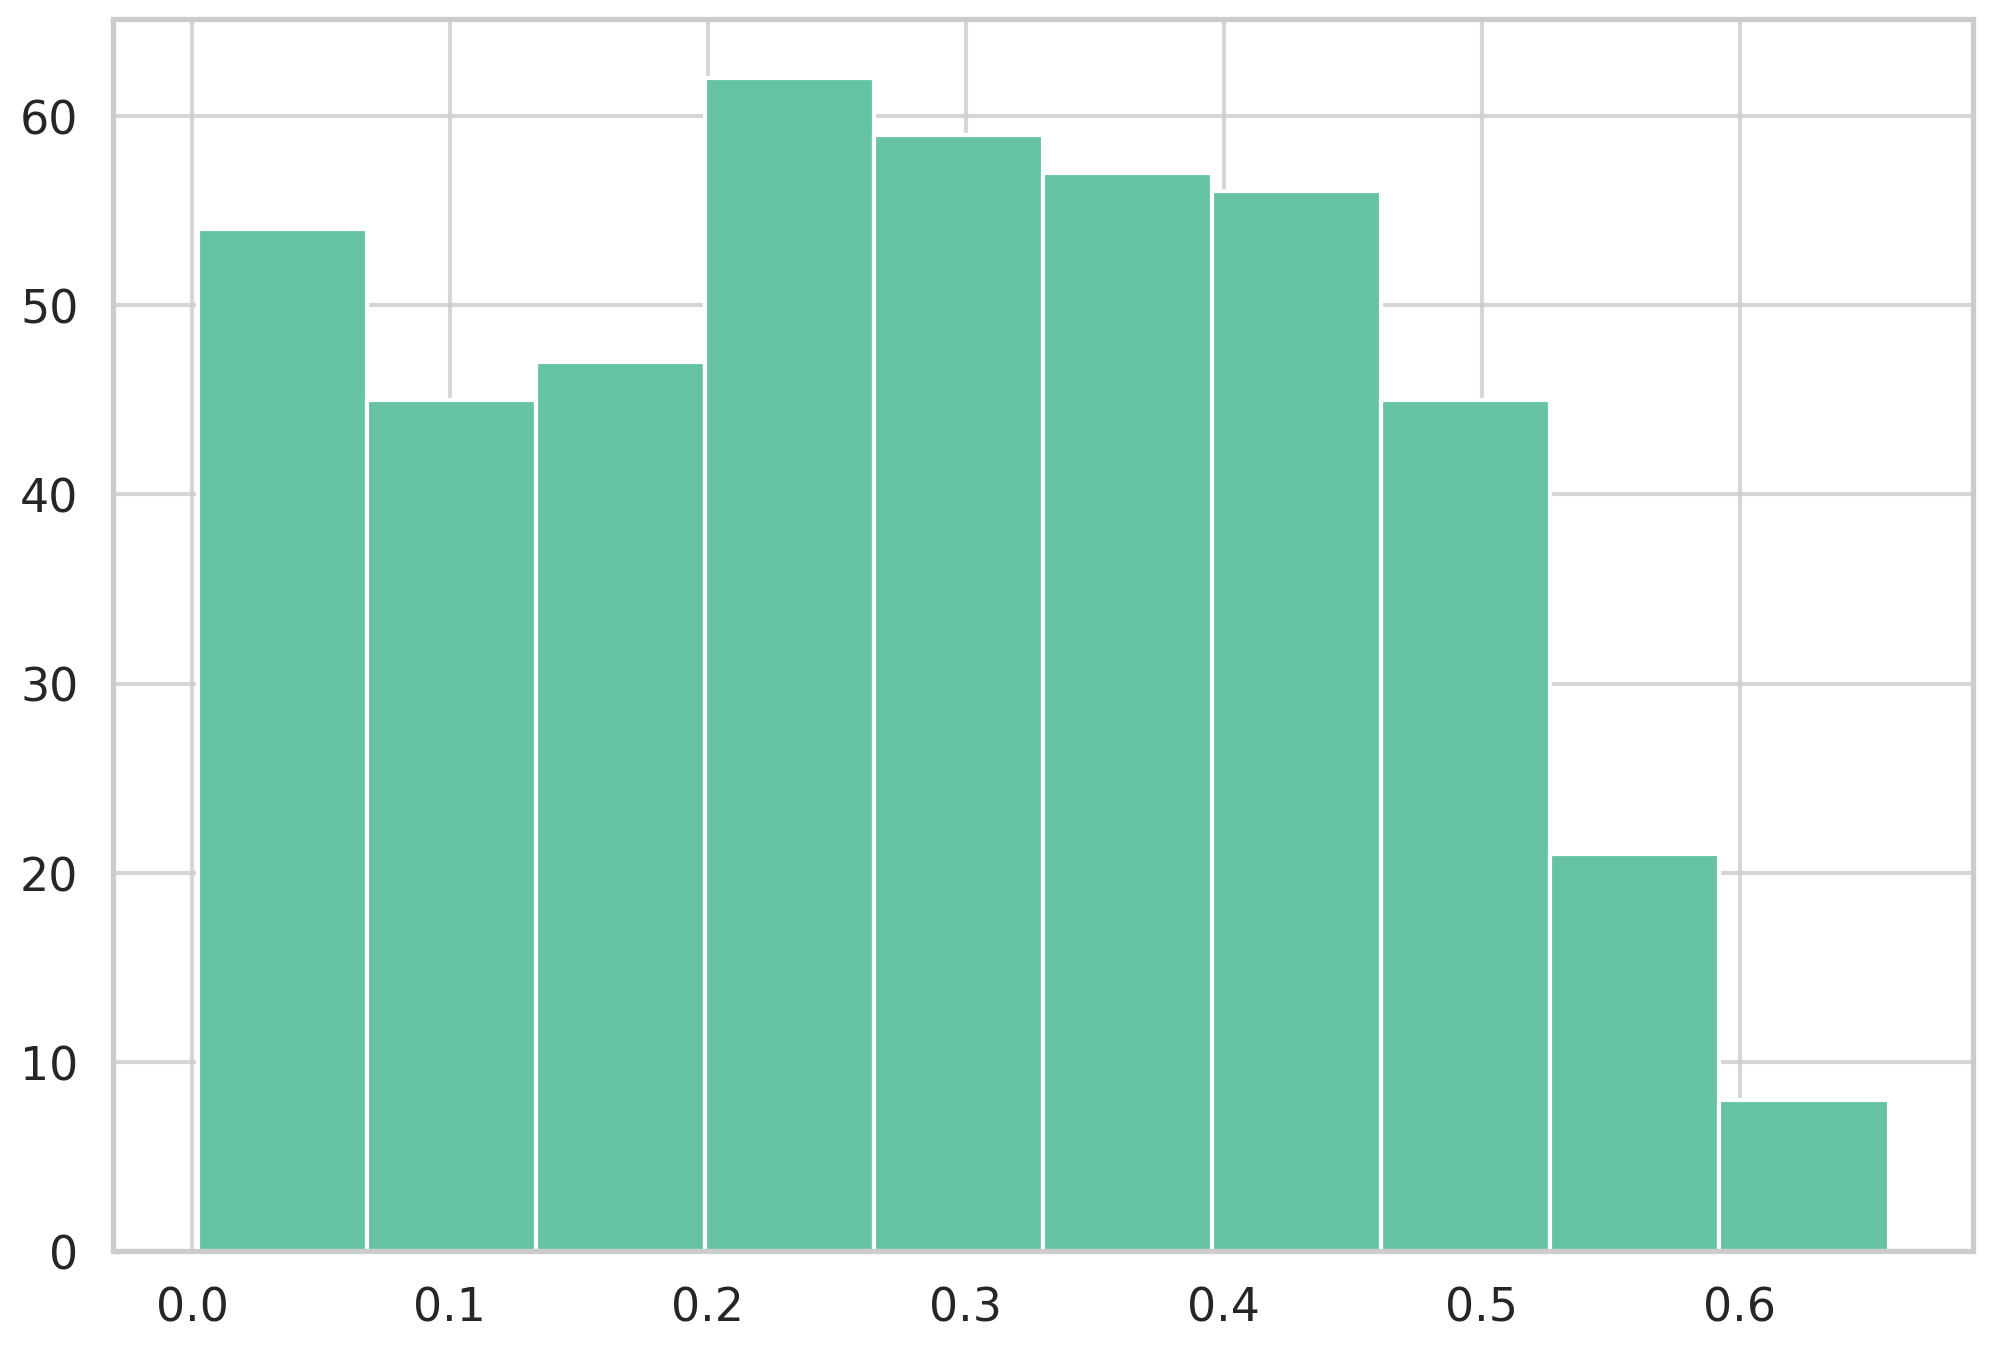

In [29]:
vis_df[value_column].hist()

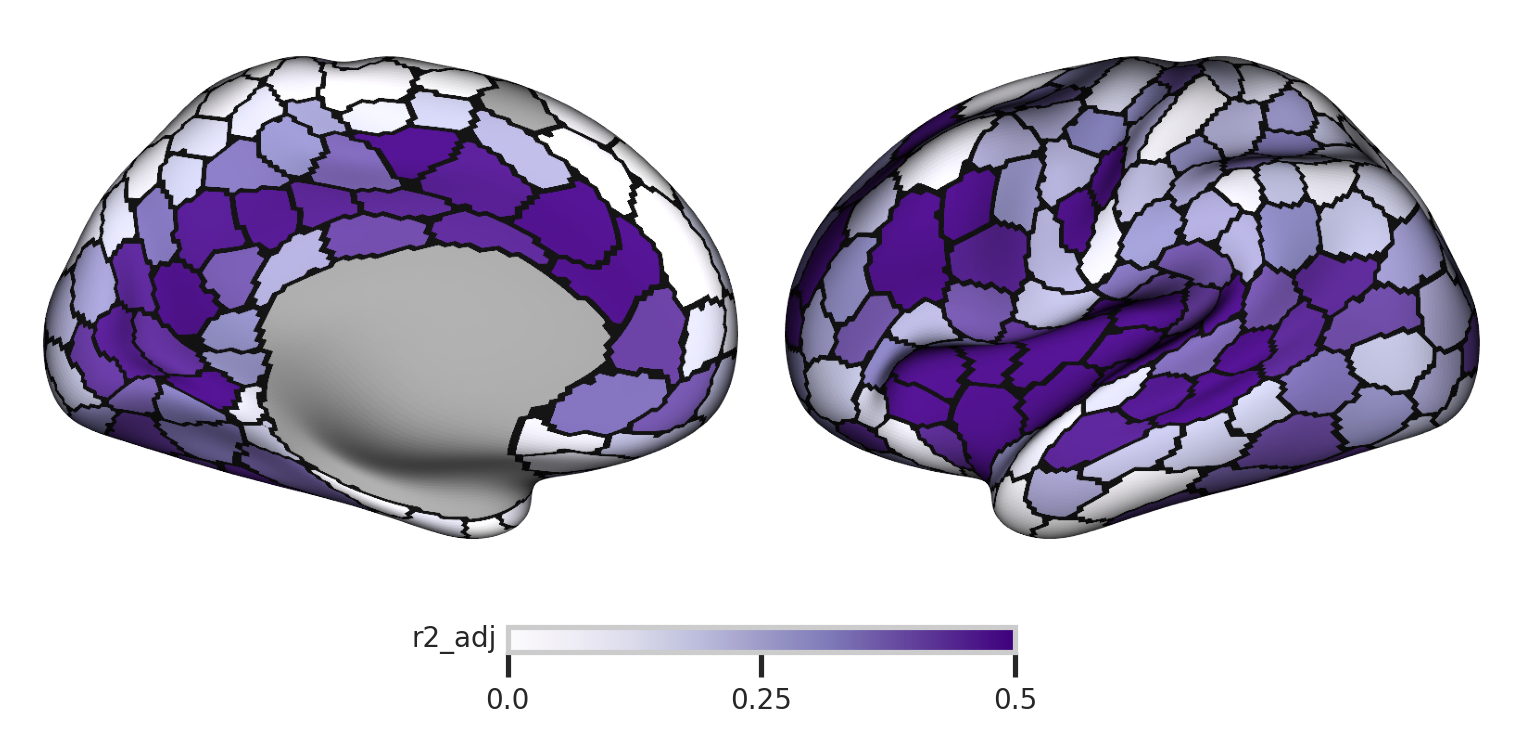

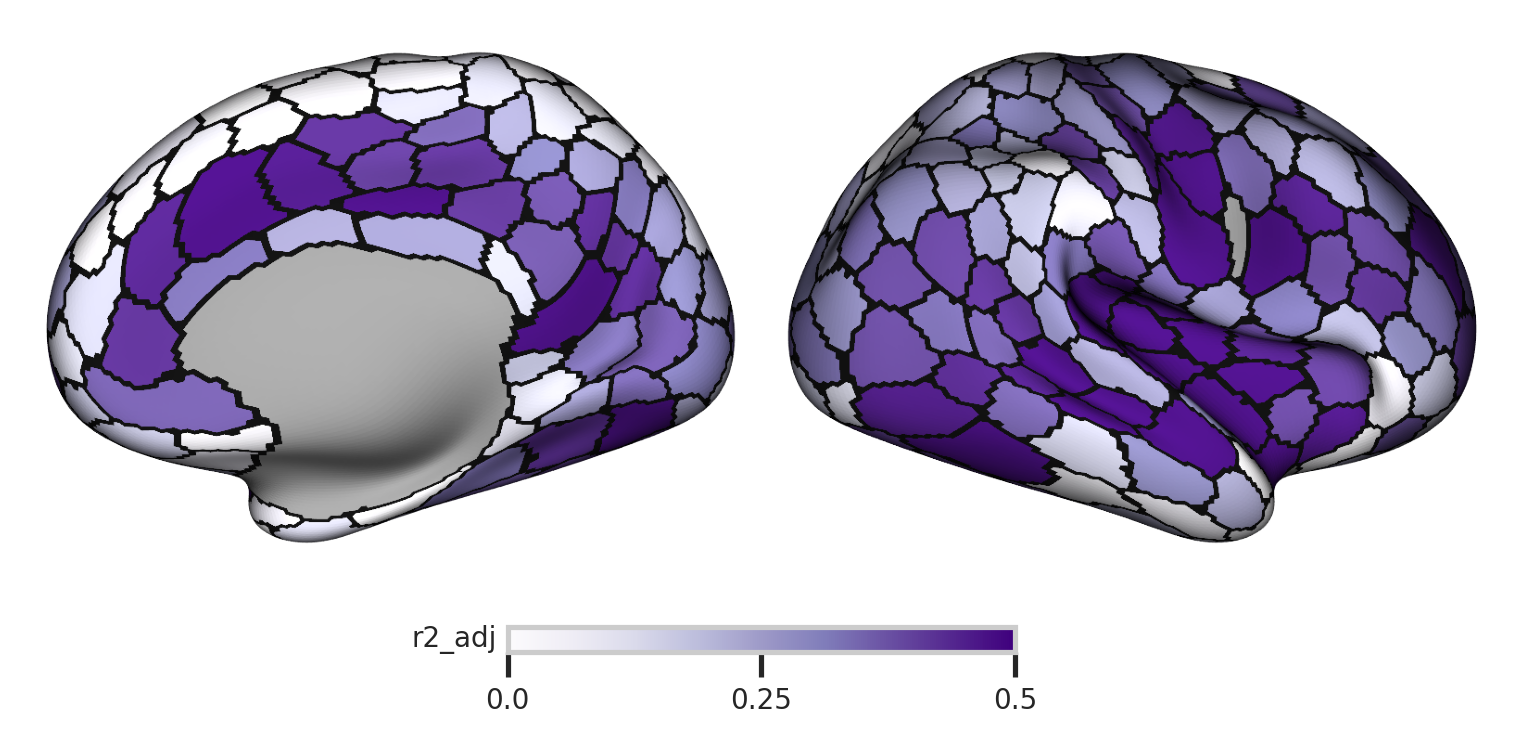

In [33]:
vmin = 0
vmax = 0.5

# Corrected loop for plotting each hemisphere independently
for hemi_key, hemi_surf_data, mapped_data, parcellation_data in zip(
    ["left", "right"],  # The key for surfplot's dictionary
    [lh, rh],  # The surface object for the current hemisphere
    [data_lh_mapped, data_rh_mapped],  # The mapped data for the current hemisphere
    [lh_parc, rh_parc],  # The parcellation for the current hemisphere
):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    pref_surf = {
        "surf_lh": hemi_surf_data if hemi_key == "left" else None,
        "surf_rh": hemi_surf_data if hemi_key == "right" else None,
    }
    p = Plot(
        **pref_surf,  # Unpack the surface dictionary
        views=["medial", "lateral"],  # Show both medial and lateral for this hemi
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",  # For a single hemisphere, row is fine
        mirror_views=False,  # Set to False, as we are plotting one hemi at a time
    )

    # ---- main data layer -------------------------------------------------
    # Pass only the data for the current hemisphere
    # The dictionary now contains only one key-value pair for the current hemisphere
    p.add_layer(
        {hemi_key: mapped_data},
        cmap="Purples",
        color_range=(vmin, vmax),  # Use symmetric range
        # norm=norm,  # Apply the symmetric normalization
        cbar_label=value_column,
        cbar=True,  # Ensure colorbar is shown for each plot if desired, or handle globally
    )
    # ---- outline layer ---------------------------------------------------
    p.add_layer({hemi_key: parcellation_data}, cmap="gray", as_outline=True, cbar=False)

    fig = p.build(
        # cbar_kws=dict(location="bottom", decimals=2, shrink=0.6)
    )  # Added cbar_kws for better cbar display
    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig2_{metric}_{hemi_key}_{value_column}.png", dpi=400)

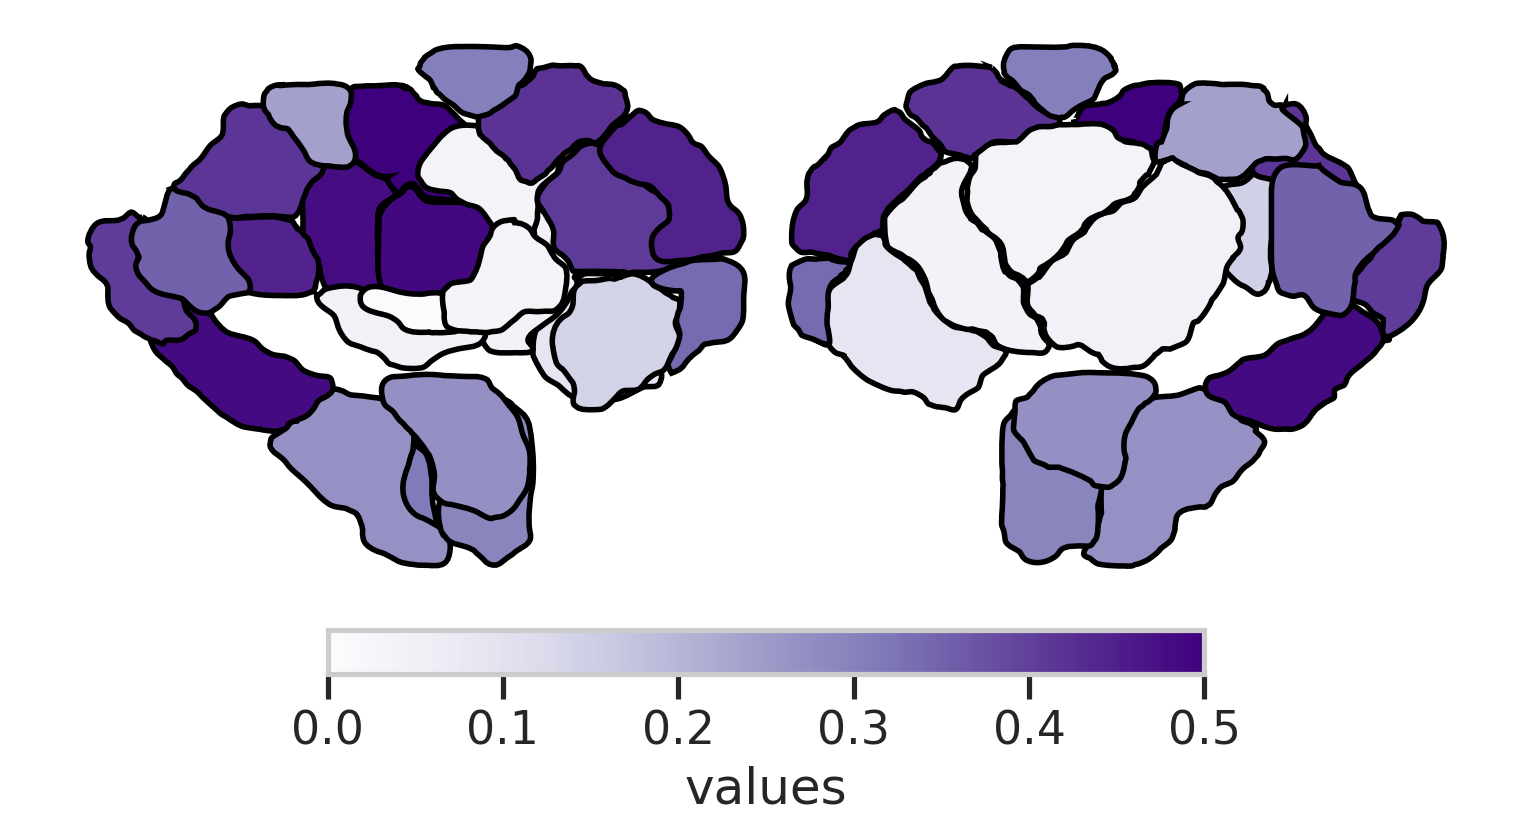

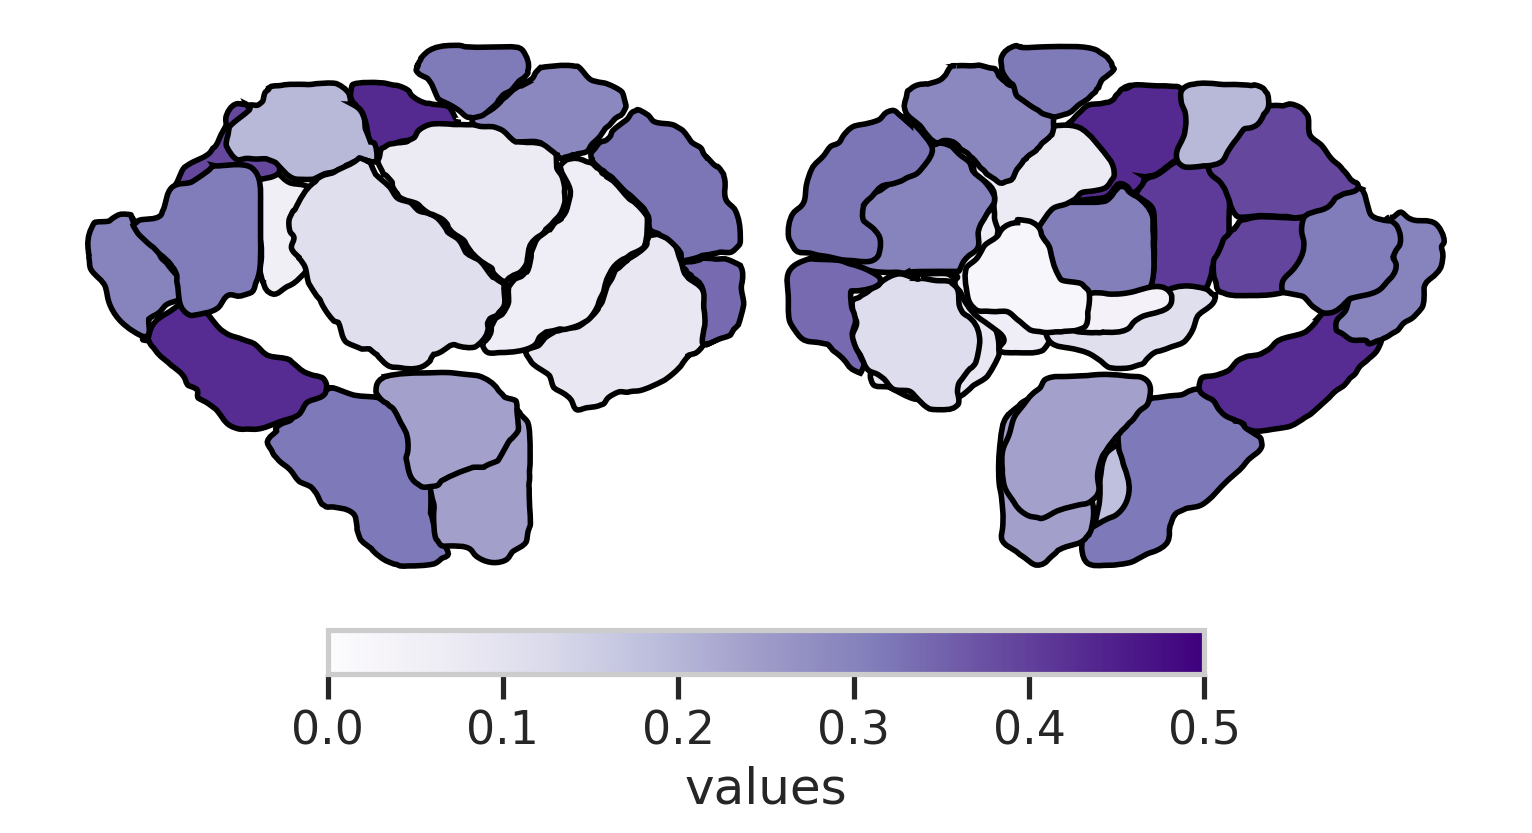

In [34]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L","R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="Purples",
        # cmap="Reds",
        line_color="black",
        line_thickness=2,
        vmin = vmin,
        vmax = vmax,
        show_figure=False
    )

    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)
